Modality-specific preprocessing and dimensionality reduction.

To understand the distribution of gene expression in the current data, we load the single-cell RNA-seq dataset and compute basic gene-level statistics such as mean expression, variance, and dispersion (variance/mean).

               mean     variance    dispersion
count  2.000000e+03  2000.000000  2.000000e+03
mean  -6.537348e-03     0.745879  4.227490e+05
std    8.117796e-03     0.348090  7.536992e+05
min   -2.387043e-02     0.009794 -4.407208e+06
25%   -1.444693e-02     0.489850 -6.273597e+01
50%   -3.202007e-04     0.993303 -4.526398e+00
75%   -3.363201e-16     0.999967  9.999674e+05
max    2.811747e-14     0.999967  2.278476e+07


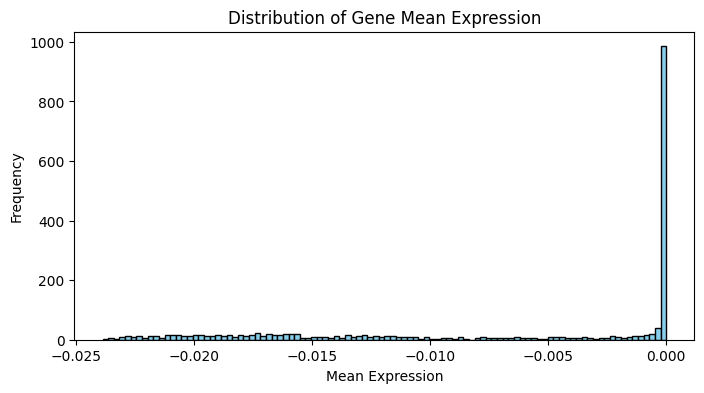

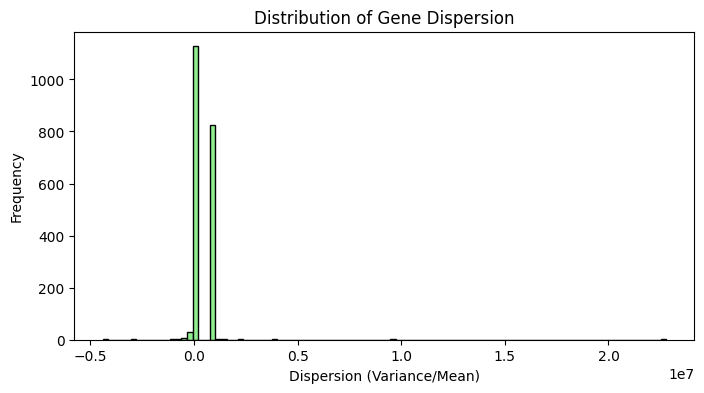

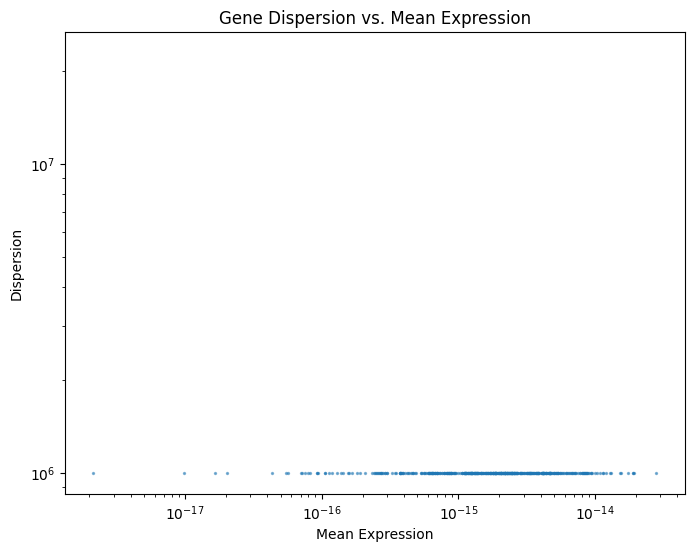

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import issparse 

adata = sc.read_h5ad("data/processed/BM-CITE_RNA.h5ad") # change this to other datasets if needed

# If the data matrix is sparse and not too huge, convert to dense for computing statistics.
X = adata.X.toarray() if issparse(adata.X) else adata.X

# Compute gene-level summary statistics: mean, variance, and dispersion (variance/mean)
gene_means = X.mean(axis=0)
gene_vars = X.var(axis=0)
# Avoid division by zero by adding a small constant
gene_dispersion = gene_vars / (gene_means + 1e-6)

# Create a DataFrame for easy inspection
gene_stats = pd.DataFrame({
    'mean': gene_means,
    'variance': gene_vars,
    'dispersion': gene_dispersion
}, index=adata.var_names)

# Print summary statistics
print(gene_stats.describe())

# Plot the distribution of gene means
plt.figure(figsize=(8, 4))
plt.hist(gene_stats['mean'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Mean Expression')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Mean Expression')
plt.show()

# Plot the distribution of gene dispersions
plt.figure(figsize=(8, 4))
plt.hist(gene_stats['dispersion'], bins=100, color='lightgreen', edgecolor='black')
plt.xlabel('Dispersion (Variance/Mean)')
plt.ylabel('Frequency')
plt.title('Distribution of Gene Dispersion')
plt.show()

# Scatter plot: dispersion vs. mean (log-log scale)
plt.figure(figsize=(8, 6))
plt.scatter(gene_stats['mean'], gene_stats['dispersion'], s=2, alpha=0.5)
plt.xlabel('Mean Expression')
plt.ylabel('Dispersion')
plt.title('Gene Dispersion vs. Mean Expression')
plt.xscale('log')
plt.yscale('log')
plt.show()

OK Let's move on to preprocess and reduce the RNA-seq data. The pipeline includes:

1. **Filtering cells and genes:** Remove cells with zero counts and genes expressed in fewer than 10 cells.
2. **Normalization:** Normalize total counts to 10,000 per cell and log-transform the data.
3. **Highly Variable Gene (HVG) selection:** Identify genes with high variability using the Seurat method.
4. **Scaling and PCA:** Scale the data and perform PCA for dimensionality reduction.

The output files will be stored in /reduced subfolder

In [ ]:
import scanpy as sc
import numpy as np
import os

def preprocess_scRNA(h5ad_in, h5ad_out=None, n_top_genes=300):
    """
    Preprocessing pipeline for single-cell RNA-seq data.
    Handles edge cases like zero variances, NaNs, and ensures valid input for downstream steps.
    """
    adata = sc.read_h5ad(h5ad_in)
    
    # Convert to dense matrix if sparse
    if not isinstance(adata.X, np.ndarray):
        adata.X = adata.X.toarray()
    
    # uncomment for filtering
    
    # # 1. Filter cells and genes
    # sc.pp.filter_cells(adata, min_counts=1)  # Remove cells with zero counts
    # sc.pp.filter_genes(adata, min_cells=10)  # Filter low-expressed genes
    
    # # 2. Normalize and handle potential NaNs/negatives
    # sc.pp.normalize_total(adata, target_sum=1e4)
    # adata.X = np.clip(adata.X, 0, None)  # Ensure non-negative values
    # adata.X = np.nan_to_num(adata.X)  # Replace any NaNs
    
    # # 3. Log-transform safely
    # sc.pp.log1p(adata)
    # adata.X = np.nan_to_num(adata.X)  # Post-log cleanup
    
    # # 4. Check if HVG selection is feasible
    # try:
    #     # Compute gene means and variances
    #     mean = np.mean(adata.X, axis=0)
    #     variance = np.var(adata.X, axis=0)
        
    #     if np.all(variance == 0) or np.any(np.isnan(mean)) or np.any(np.isnan(variance)):
    #         raise ValueError("Insufficient variance or NaNs detected.")
        
    #     # Select HVGs with Seurat method
    #     sc.pp.highly_variable_genes(
    #         adata,
    #         flavor='seurat',
    #         n_top_genes=n_top_genes,
    #         min_mean=0.1,
    #         max_mean=3,
    #         min_disp=0.5
    #     )
    #     hvgs = adata.var[adata.var.highly_variable].index
    # except Exception as e:
    #     print(f"HVG selection failed: {str(e)}. Using all genes.")
    #     hvgs = adata.var.index
    
    # # 5. Subset to HVGs and proceed with scaling/PCA
    # adata = adata[:, hvgs]
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='randomized')
    
    # if h5ad_out is not None:
    #     adata.write_h5ad(h5ad_out)
    
    return adata

# List all RNA files
rna_files = [f for f in os.listdir("data/processed") if f.endswith("_RNA.h5ad")]

# Process each RNA file
for rna_file in rna_files:
    input_file = os.path.join("data/processed", rna_file)
    output_file = os.path.join("data/processed/reduced", rna_file.replace(".h5ad", "_processed.h5ad"))
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    print(f"Processing {input_file}...")
    adata = preprocess_scRNA(input_file, output_file, n_top_genes=300)
    print(f"Saved processed data to {output_file}\n")

Processing data/processed\BM-CITE_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\BM-CITE_RNA_processed.h5ad

Processing data/processed\LUNG-CITE_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\LUNG-CITE_RNA_processed.h5ad

Processing data/processed\PBMC-DOGMA_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\PBMC-DOGMA_RNA_processed.h5ad

Processing data/processed\PBMC-Multiome_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\PBMC-Multiome_RNA_processed.h5ad

Processing data/processed\PBMC-TEA_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\PBMC-TEA_RNA_processed.h5ad

Processing data/processed\Skin-SHARE_RNA.h5ad...


c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_normalization.py:235: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:252: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)
c:\Users\sonia\anaconda3\envs\omics_env\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Saved processed data to data/processed/reduced\Skin-SHARE_RNA_processed.h5ad



Sanity check: show PCA plots for each file.

<Figure size 800x600 with 0 Axes>

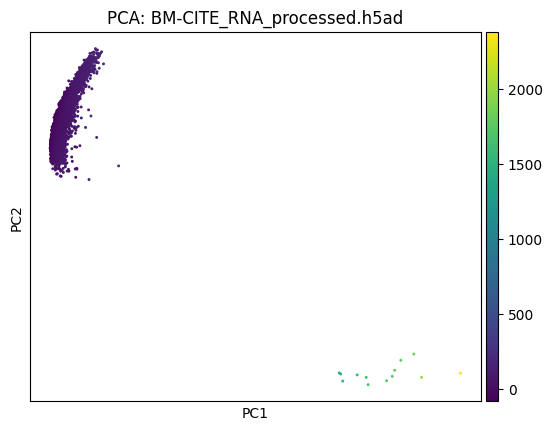

<Figure size 800x600 with 0 Axes>

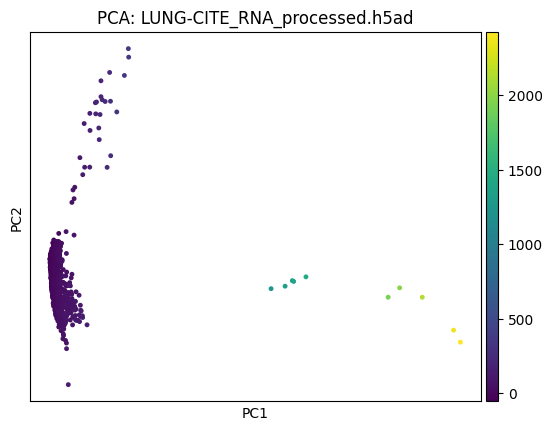

<Figure size 800x600 with 0 Axes>

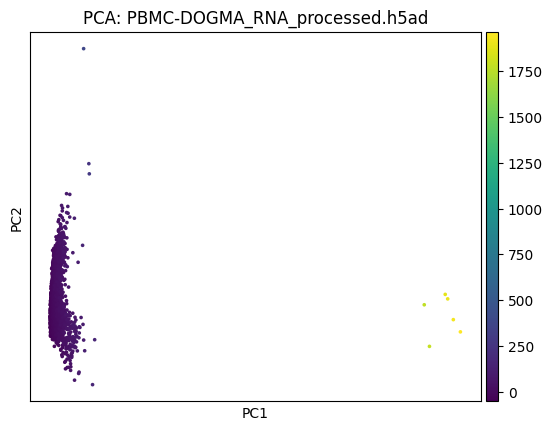

<Figure size 800x600 with 0 Axes>

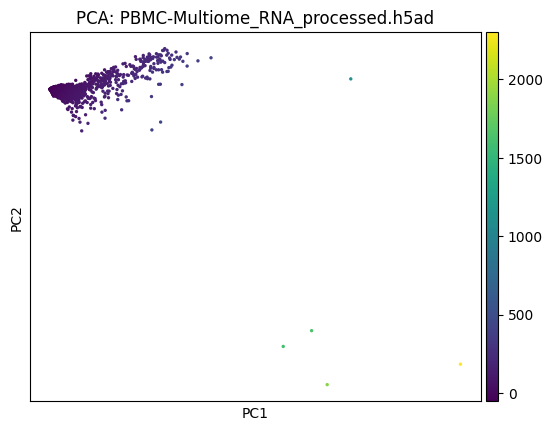

<Figure size 800x600 with 0 Axes>

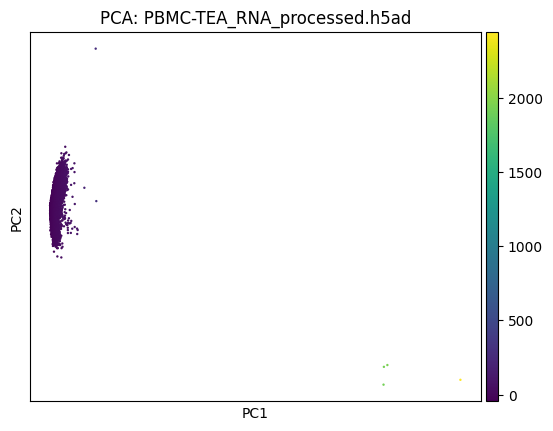

<Figure size 800x600 with 0 Axes>

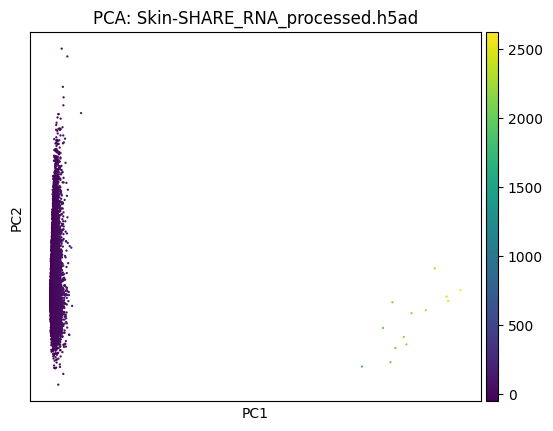

In [4]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import os

# Directory containing preprocessed files
processed_dir = "data/processed/reduced"

# List all preprocessed RNA files
rna_files = [f for f in os.listdir(processed_dir) if f.endswith("_RNA_processed.h5ad")]

# Plot PCA for each file
for rna_file in rna_files:
    # Load the preprocessed data
    adata = sc.read_h5ad(os.path.join(processed_dir, rna_file))
    
    # Compute total counts per cell
    if "total_counts" not in adata.obs:
        adata.obs["total_counts"] = np.sum(adata.X, axis=1)
    
    # Plot PCA components
    plt.figure(figsize=(8, 6))
    sc.pl.pca(adata, color="total_counts", title=f"PCA: {rna_file}")
    plt.show()

Now let's do some data analysis before deciding on filtering params for ADT data

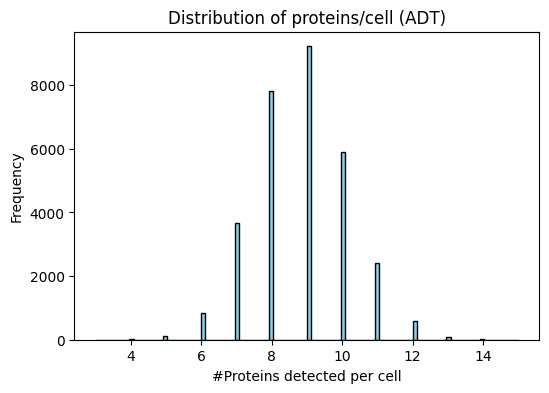

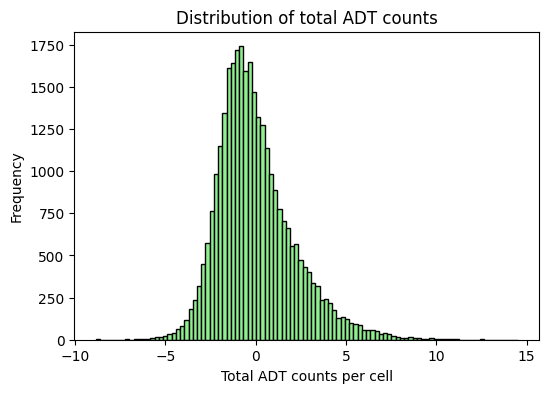

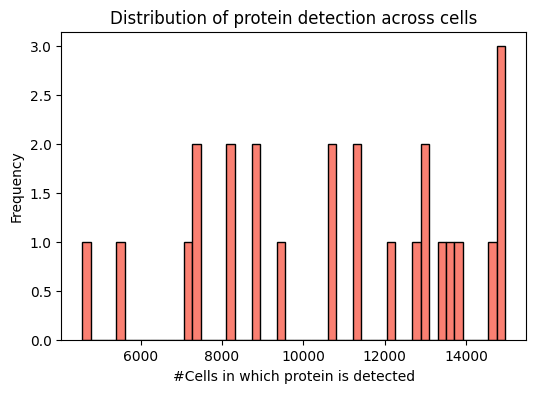

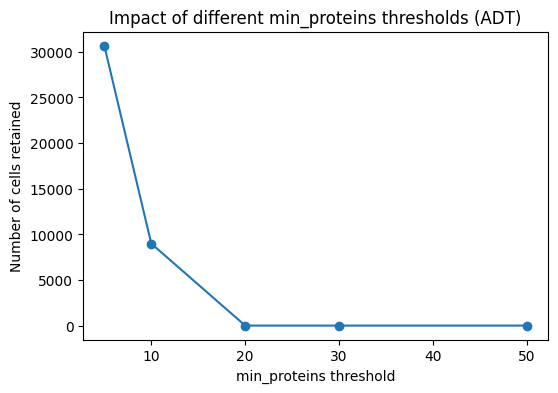

In [ ]:
# =============== ADT Data Exploration ===============
adt_file = "data/processed/BM-CITE_ADT.h5ad" # change to see other files
adata_adt = sc.read_h5ad(adt_file)

from scipy.sparse import issparse

# 1) Number of proteins detected per cell
if issparse(adata_adt.X):
    adata_adt.obs["n_proteins"] = (adata_adt.X > 0).sum(axis=1).A1
else:
    adata_adt.obs["n_proteins"] = (adata_adt.X > 0).sum(axis=1)

# 2) Total ADT counts per cell
if issparse(adata_adt.X):
    adata_adt.obs["total_ADT_counts"] = adata_adt.X.sum(axis=1).A1
else:
    adata_adt.obs["total_ADT_counts"] = adata_adt.X.sum(axis=1)

# --- Plot # of proteins per cell ---
plt.figure(figsize=(6,4))
plt.hist(adata_adt.obs["n_proteins"], bins=100, color="skyblue", edgecolor="black")
plt.xlabel("#Proteins detected per cell")
plt.ylabel("Frequency")
plt.title("Distribution of proteins/cell (ADT)")
plt.show()

# --- Plot total ADT counts per cell ---
plt.figure(figsize=(6,4))
plt.hist(adata_adt.obs["total_ADT_counts"], bins=100, color="lightgreen", edgecolor="black")
plt.xlabel("Total ADT counts per cell")
plt.ylabel("Frequency")
plt.title("Distribution of total ADT counts")
plt.show()

# 3) Number of cells in which each protein is detected
if issparse(adata_adt.X):
    n_cells_per_protein = (adata_adt.X > 0).sum(axis=0).A1
else:
    n_cells_per_protein = (adata_adt.X > 0).sum(axis=0)

plt.figure(figsize=(6,4))
plt.hist(n_cells_per_protein, bins=50, color="salmon", edgecolor="black")
plt.xlabel("#Cells in which protein is detected")
plt.ylabel("Frequency")
plt.title("Distribution of protein detection across cells")
plt.show()

# 4) Test different thresholds for min_proteins
thresholds = [5, 10, 20, 30, 50]
remaining_cells = []
for t in thresholds:
    tmp = adata_adt.copy()
    # Filter out cells with fewer than 't' detected proteins
    sc.pp.filter_cells(tmp, min_genes=t)
    remaining_cells.append(tmp.n_obs)

plt.figure(figsize=(6,4))
plt.plot(thresholds, remaining_cells, marker='o')
plt.xlabel("min_proteins threshold")
plt.ylabel("Number of cells retained")
plt.title("Impact of different min_proteins thresholds (ADT)")
plt.show()


ADT (antibody-derived tag) - arcsinh transform instead of log1p, otherwise very similar workflow to RNA (filter cells, filter low-abundance proteins, scale, PCA)

In [ ]:
import scanpy as sc
import numpy as np
import os
from scipy.sparse import issparse

def preprocess_ADT(h5ad_in, h5ad_out=None, cofactor=5, min_proteins=8, min_cells=10):
    """
    ADT preprocessing pipeline:
      1. Filter low-quality cells & proteins
      2. Apply arcsinh transformation
      3. Scale the data
      4. Perform PCA
    Saves the processed data if h5ad_out is provided.
    """
    adata = sc.read_h5ad(h5ad_in)

    # 1. Filter low-quality cells (based on number of detected proteins)
    sc.pp.filter_cells(adata, min_counts=min_proteins)
    sc.pp.filter_genes(adata, min_cells=min_cells)

    # 2. Convert sparse matrix to dense
    if issparse(adata.X):
        adata.X = adata.X.toarray()

    # 3. Apply arcsinh transformation
    adata.X = np.arcsinh(adata.X / cofactor)

    # 4. Scale & PCA
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='randomized')

    # Save
    if h5ad_out is not None:
        adata.write_h5ad(h5ad_out)

    return adata

# Process all ADT files
adt_files = [f for f in os.listdir("data/processed") if f.endswith("_ADT.h5ad")]
for adt_file in adt_files:
    input_file = os.path.join("data/processed", adt_file)
    output_file = os.path.join("data/processed/reduced", adt_file.replace(".h5ad", "_processed.h5ad"))
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    print(f"Processing ADT file: {input_file}")
    adata_adt = preprocess_ADT(input_file, output_file, cofactor=5, min_proteins=8, min_cells=10)
    print(f"Saved processed ADT: {output_file}\n")

Processing ADT file: data/processed\BM-CITE_ADT.h5ad
Saved processed ADT: data/processed/reduced\BM-CITE_ADT_processed.h5ad

Processing ADT file: data/processed\LUNG-CITE_ADT.h5ad
Saved processed ADT: data/processed/reduced\LUNG-CITE_ADT_processed.h5ad



Data exploration for ATAC

In [19]:
import h5py
import os

def remove_lsi_key(h5ad_path):
    """
    Opens the .h5ad file with h5py and removes the varm/LSI key
    if it exists. This prevents shape mismatch errors upon reading.
    """
    with h5py.File(h5ad_path, "r+") as f:
        # Navigate to 'varm' group if it exists
        if "varm" in f:
            varm_group = f["varm"]
            # Check if LSI is in varm
            if "LSI" in varm_group:
                print(f"Removing varm/LSI from {h5ad_path} ...")
                del varm_group["LSI"]
            if "LSI.RAW" in varm_group: del varm_group["LSI.RAW"]
            if "LSI_SVD" in varm_group: del varm_group["LSI_SVD"]


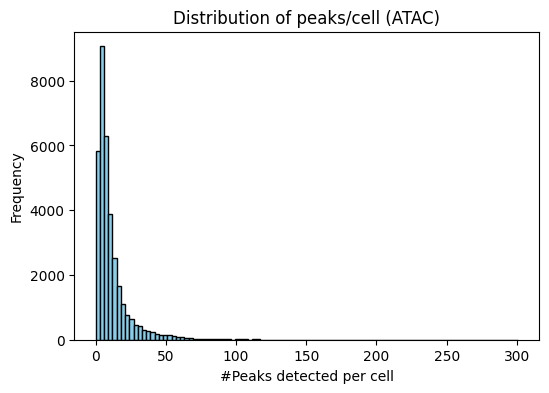

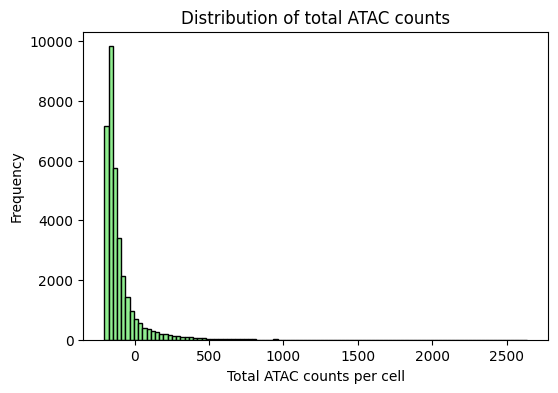

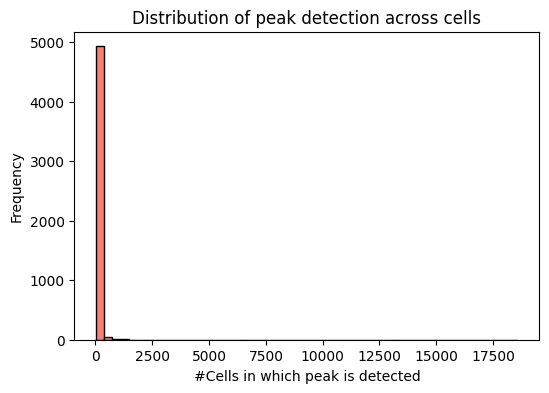

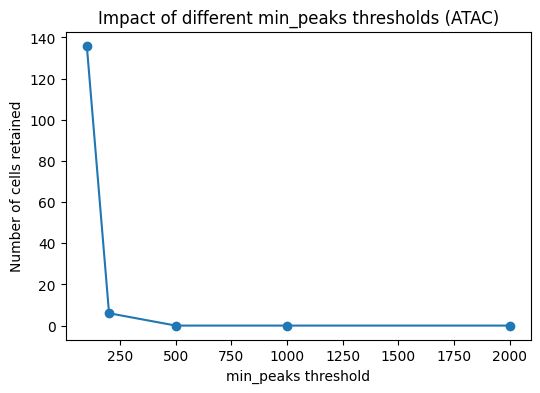

In [22]:
# =============== ATAC Data Exploration ===============
atac_file = "data/processed/Skin-SHARE_Peaks.h5ad"
adata_atac = sc.read_h5ad(atac_file)

from scipy.sparse import issparse

# 1) Number of peaks detected per cell
if issparse(adata_atac.X):
    adata_atac.obs["n_peaks"] = (adata_atac.X > 0).sum(axis=1).A1
else:
    adata_atac.obs["n_peaks"] = (adata_atac.X > 0).sum(axis=1)

# 2) Total ATAC counts per cell
if issparse(adata_atac.X):
    adata_atac.obs["total_ATAC_counts"] = adata_atac.X.sum(axis=1).A1
else:
    adata_atac.obs["total_ATAC_counts"] = adata_atac.X.sum(axis=1)

# --- Plot # of peaks per cell ---
plt.figure(figsize=(6,4))
plt.hist(adata_atac.obs["n_peaks"], bins=100, color="skyblue", edgecolor="black")
plt.xlabel("#Peaks detected per cell")
plt.ylabel("Frequency")
plt.title("Distribution of peaks/cell (ATAC)")
plt.show()

# --- Plot total ATAC counts per cell ---
plt.figure(figsize=(6,4))
plt.hist(adata_atac.obs["total_ATAC_counts"], bins=100, color="lightgreen", edgecolor="black")
plt.xlabel("Total ATAC counts per cell")
plt.ylabel("Frequency")
plt.title("Distribution of total ATAC counts")
plt.show()

# 3) Number of cells in which each peak is detected
if issparse(adata_atac.X):
    n_cells_per_peak = (adata_atac.X > 0).sum(axis=0).A1
else:
    n_cells_per_peak = (adata_atac.X > 0).sum(axis=0)

plt.figure(figsize=(6,4))
plt.hist(n_cells_per_peak, bins=50, color="salmon", edgecolor="black")
plt.xlabel("#Cells in which peak is detected")
plt.ylabel("Frequency")
plt.title("Distribution of peak detection across cells")
plt.show()

# 4) Test different thresholds for min_peaks
thresholds = [100, 200, 500, 1000, 2000]
remaining_cells = []
for t in thresholds:
    tmp = adata_atac.copy()
    sc.pp.filter_cells(tmp, min_genes=t)  # 'min_genes' also works for peaks
    remaining_cells.append(tmp.n_obs)

plt.figure(figsize=(6,4))
plt.plot(thresholds, remaining_cells, marker='o')
plt.xlabel("min_peaks threshold")
plt.ylabel("Number of cells retained")
plt.title("Impact of different min_peaks thresholds (ATAC)")
plt.show()


ATAC preprocessing: filter cells/peaks, binarize the peak matrix, normalize/log-transform, scale, PCA. Might consider specialised transformation like TF-IDF or LSI

In [23]:
import scanpy as sc
import numpy as np
from scipy.sparse import issparse

def preprocess_scATAC(h5ad_in, h5ad_out=None,
                      binarize=True,
                      min_peaks_per_cell=500,
                      min_cells_per_peak=10):
    """
    Minimal scATAC preprocessing:
      1) Remove LSI key if shape-mismatch
      2) Filter low-quality cells & peaks
      3) Binarize
      4) Normalize & log-transform
      5) Scale & PCA
    """
    # 1. Remove LSI key from h5ad if it exists
    remove_lsi_key(h5ad_in)
    
    # 2. Load data
    adata = sc.read_h5ad(h5ad_in)
    
    # Filter cells & peaks
    sc.pp.filter_cells(adata, min_genes=min_peaks_per_cell)  
    sc.pp.filter_genes(adata, min_cells=min_cells_per_peak)  

    # Binarize
    X = adata.X.toarray() if issparse(adata.X) else adata.X
    if binarize:
        X = (X > 0).astype(np.float32)
    adata.X = X

    # If nothing remains, skip normalization & PCA
    if adata.n_obs < 2 or adata.n_vars < 2:
        print(f"Warning: After filtering, shape={adata.shape}. Skipping PCA.")
        if h5ad_out is not None:
            adata.write_h5ad(h5ad_out)
        return adata

    # Normalize & log-transform
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Scale & PCA
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver='randomized')

    # Save
    if h5ad_out is not None:
        adata.write_h5ad(h5ad_out)

    return adata

# Identify ATAC files
atac_files = [
    f for f in os.listdir("data/processed")
    if f.endswith("_atac.h5ad") or f.endswith("_Peaks.h5ad")
]

for atac_file in atac_files:
    input_file = os.path.join("data/processed", atac_file)
    output_file = os.path.join(
        "data/processed/reduced",
        atac_file.replace(".h5ad", "_processed.h5ad")
    )
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    print(f"Processing ATAC file: {input_file}")
    
    adata_atac = preprocess_scATAC(
        h5ad_in=input_file,
        h5ad_out=output_file,
        binarize=True,
        min_peaks_per_cell=200,
        min_cells_per_peak=10
    )
    
    print(f"Saved processed ATAC: {output_file}\n")

Processing ATAC file: data/processed\PBMC-DOGMA_atac.h5ad
Saved processed ATAC: data/processed/reduced\PBMC-DOGMA_atac_processed.h5ad

Processing ATAC file: data/processed\PBMC-Multiome_Peaks.h5ad
Saved processed ATAC: data/processed/reduced\PBMC-Multiome_Peaks_processed.h5ad

Processing ATAC file: data/processed\PBMC-TEA_atac.h5ad
Saved processed ATAC: data/processed/reduced\PBMC-TEA_atac_processed.h5ad

Processing ATAC file: data/processed\Skin-SHARE_Peaks.h5ad
Saved processed ATAC: data/processed/reduced\Skin-SHARE_Peaks_processed.h5ad



PCA visualisation for ADT and ATAC

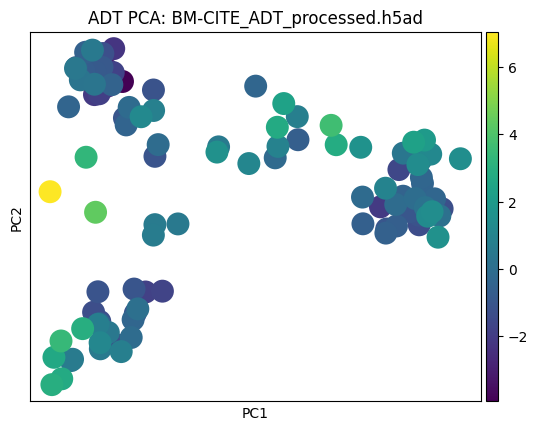

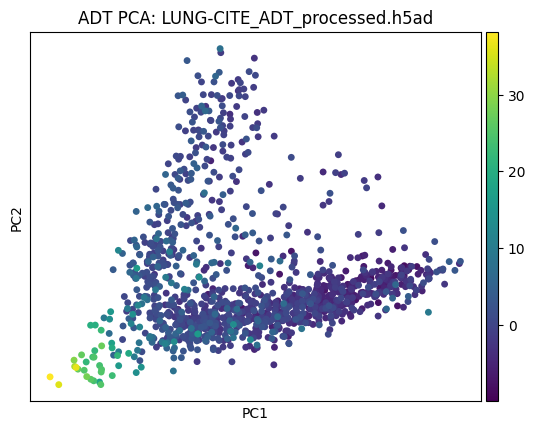

In [25]:
processed_dir = "data/processed/reduced"

# ADT
adt_processed_files = [f for f in os.listdir(processed_dir) if f.endswith("_ADT_processed.h5ad")]
for fname in adt_processed_files:
    adata_adt = sc.read_h5ad(os.path.join(processed_dir, fname))

    # Compute total counts if missing
    if "total_counts" not in adata_adt.obs:
        adata_adt.obs["total_counts"] = np.sum(adata_adt.X, axis=1)

    sc.pl.pca(adata_adt, color="total_counts", title=f"ADT PCA: {fname}")
    plt.show()


Note the error in the last PCA plot is due to that file not having enough dimensions for PCA in filtering step

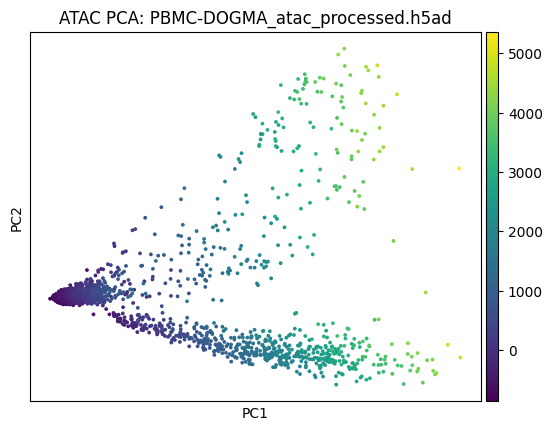

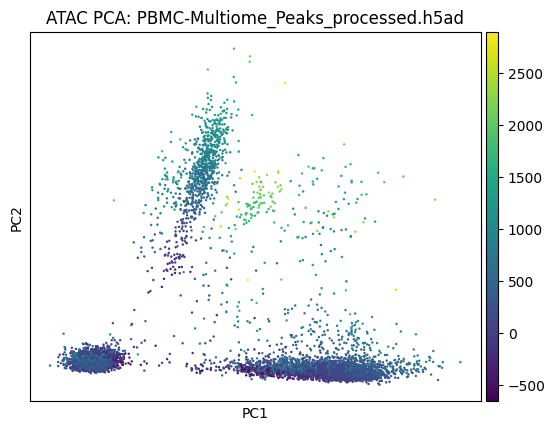

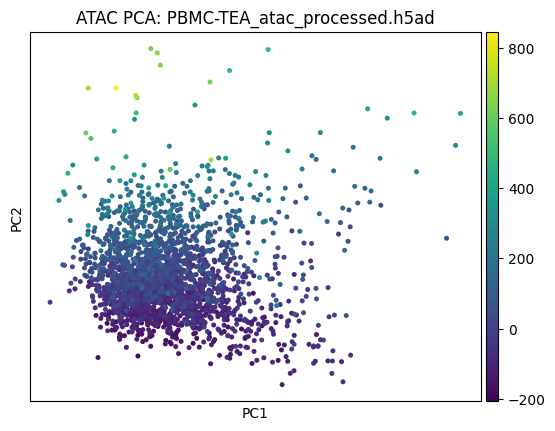

KeyError: "Could not find 'pca' or 'X_pca' in .obsm"

In [26]:
# ATAC
atac_processed_files = [f for f in os.listdir(processed_dir) if f.endswith("_atac_processed.h5ad") or f.endswith("_Peaks_processed.h5ad")]
for fname in atac_processed_files:
    adata_atac = sc.read_h5ad(os.path.join(processed_dir, fname))

    # Compute total counts if missing
    if "total_counts" not in adata_atac.obs:
        adata_atac.obs["total_counts"] = np.sum(adata_atac.X, axis=1)

    sc.pl.pca(adata_atac, color="total_counts", title=f"ATAC PCA: {fname}")
    plt.show()
